# Controlling a Cart in a 1D Space

### The Challenge

In this demo, we consider a cart that can move in a 1D space. At each time step the cart can be steered a bit to the left or right by a controller (the "agent"). The agent's knowledge about the cart's process dynamics (equations of motion) are known up to some additive Gaussian process noise. The agent also makes noisy observations of the position and velocity of the cart. Your challenge is to design an agent that steers the car to the zero position. (The agent should be specified as a probabilistic model and the control signal should be formulated as a Bayesian inference task).  

<img src="agent-cart-interaction.png" width="500px">


### Set up environment


In [1]:
using Pkg;Pkg.activate("../probprog/workspace/");Pkg.instantiate()
using Random
Random.seed!(87613) # Set random seed

using LinearAlgebra
using PyPlot
using ForneyLab

include("environment_1d.jl") # Include environmental dynamics
include("helpers_1d.jl") # Include helper functions for plotting
include("agent_1d.jl") # Load agent's internal beliefs over external dynamics
IJulia.clear_output()
;

### Build model

Here we specify the generative model for the agent. We define a state-space model that includes prior beliefs about desired future outcomes. The target future outcome is position $0$ (zero).
\begin{align*}
    p_t(o, s, u) &\propto p(s_{t-1}) \prod_{k=t}^{t+T} p(o_k | s_k)\, p(s_k | s_{k-1}, u_k)\, p(u_k)\, \tilde{p}(o_k)\,.
\end{align*}

We further detail the model by making the following assumptions:
\begin{align*}
    p(s_{t-1}) &= \mathcal{N}(s_{t-1} | m_{s, t-t}, v_{s, t-1})\\
    p(s_k | s_{k-1}, u_k) &= \mathcal{N}(s_k | s_{k-1} + u_k, \gamma^{-1})\\
    p(o_k | s_k) &= \mathcal{N}(o_k | s_k, \phi^{-1})\\
    p(u_k) &= \mathcal{N}(u_k | 0, \upsilon) \text{, for } k>t\\
    \tilde{p}(o_k) &= \mathcal{N}(o_k | 0, \sigma) \text{, for } k>t\\
    p(u_t) &= \delta(u_t - \hat{u}_t)\\
    \tilde{p}(o_t) &= \delta(o_t - \hat{o}_t)\,.
\end{align*}

In [2]:
# Internal model perameters
gamma   = 100.0 # Transition precision
phi     = 10.0 # Observation precision
upsilon = 1.0 # Control prior variance
sigma   = 1.0 # Goal prior variance
;

In [3]:
T = 10 # Lookahead

# Build internal model
fg = FactorGraph()

o = Vector{Variable}(undef, T) # Observed states
s = Vector{Variable}(undef, T) # Noisy brain states
u = Vector{Variable}(undef, T) # Control states

@RV s_t_min ~ GaussianMeanVariance(placeholder(:m_s_t_min),
                                   placeholder(:v_s_t_min)) # Prior brain state
u_t = placeholder(:u_t)
@RV u[1] ~ GaussianMeanVariance(u_t, tiny)
@RV s[1] ~ GaussianMeanPrecision(s_t_min + u[1], gamma)
@RV o[1] ~ GaussianMeanPrecision(s[1], phi)
placeholder(o[1], :o_t)

s_k_min = s[1]
for k=2:T
    @RV u[k] ~ GaussianMeanVariance(0.0, upsilon) # Control prior
    @RV s[k] ~ GaussianMeanPrecision(s_k_min + u[k], gamma) # State transition model
    @RV o[k] ~ GaussianMeanPrecision(s[k], phi) # Observation model
    GaussianMeanVariance(o[k], 
                         placeholder(:m_o, var_id=:m_o_*k, index=k-1),
                         placeholder(:v_o, var_id=:v_o_*k, index=k-1)) # Goal prior
    s_k_min = s[k]
end
;

### Infer algorithm

Next, we call upon [ForneyLab](http://forneylab.org) package to generate a message passing algorithm to *infer* the next action. 

In [4]:
# Schedule message passing algorithm
algo = sumProductAlgorithm(u[2]) # Infer internal states
eval(Meta.parse(algo)) # Loads the step!() function for inference
inspectSnippet(algo) # Inspect a snippet of the algorithm code
;

function step!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 59))

messages[1] = ruleSPGaussianMeanVarianceOutNPP(nothing, Message(Univariate, PointMass, m=0.0), Message(Univariate, PointMass, m=1.0))
messages[2] = ruleSPGaussianMeanVarianceOutNPP(nothing, Message(Univariate, PointMass, m=data[:m_s_t_min]), Message(Univariate, PointMass, m=data[:v_s_t_min]))
messages[3] = ruleSPGaussianMeanVarianceOutNPP(nothing, Message(Univariate, PointMass, m=data[:u_t]), Message(Univariate, PointMass, m=1.0e-12))
messages[4] = ruleSPAdditionOutNGG(nothing, messages[2], messages[3])

...

marginals[:u_2] = messages[1].dist * messages[59].dist

return marginals

end


Note that the inference algorithm completely consists of a sequence of messages. 

### Execute algorithm

Now we run this message passing algorithm for each time step so as to infer the next action. And when we're done, we plot the position of the cart as a function of time. Note that the cart get steered to the target position.

In [5]:
# Initial state
s_0 = 2.0
;

In [6]:
N = 20 # Total simulation time

(execute, observe)  = initializeWorld() # Let there be a world
(infer, act, slide) = initializeAgent() # Let there be an agent

# Step through action-perception loop
u_hat = Vector{Float64}(undef, N) # Actions
o_hat = Vector{Float64}(undef, N) # Observations
for t=1:N
    u_hat[t] = act() # Evoke an action from the agent
               execute(u_hat[t]) # The action influences hidden external states
    o_hat[t] = observe() # Observe the current environmental outcome (update p)
               infer(u_hat[t], o_hat[t]) # Infer beliefs from current model state (update q)
               slide() # Prepare for next iteration
end
;

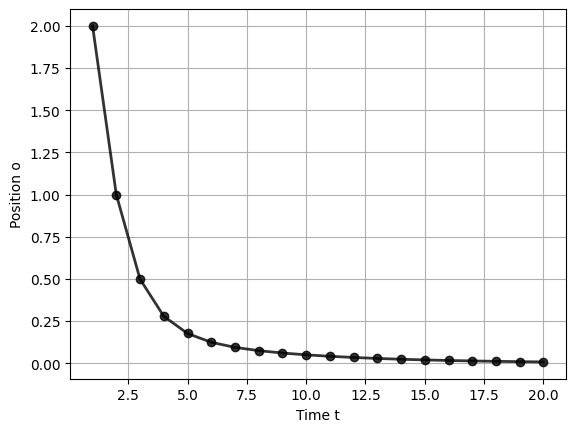

In [7]:
# Plot active inference results
plotTrajectory(u_hat, o_hat)
;

We conclude that it is possible to design an agent that makes goal-directed actions in an uncertain environment, solely based on (automatable) Bayesian inference in a generative model of the environment that is constrained by priors on future outcomes. 